# Results 2a: Data Quality

In [1]:
import os
import numpy as np
from pandas import read_csv
from tqdm import tqdm

## Section 1: Proportion of Participants Flagged 

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
scores = read_csv(os.path.join('data', 'scores.csv'))

## Restrict participants.
metrics = read_csv(os.path.join('data', 'metrics.csv'))
scores = scores[scores.subject.isin(metrics.subject)].reset_index(drop=True)

## Merge DataFrames.
data = scores.merge(metrics[['platform','subject','infreq']])

## Re-format infrequency.
data['infreq'] = np.where(data['infreq'] > 0, 1, 0)

### 1.1 WSLS Threshold

In [3]:
np.random.seed(47404)

## Define parameters.
n_perm = 5000 
n_trial = 200

## Main loop.
wsls = []
for _ in range(n_perm):
    
    ## Sample latent statistics.
    p1 = np.min([np.random.normal(0.7,0.1), 0.95])    # Observed stay dist.
    p2 = np.random.normal(0.5, 0.05)                  # Observed reward dist.
    
    ## Simulate trial-history regressors.
    y = np.random.binomial(1, p1, n_trial)
    r = np.random.binomial(1, p2, n_trial)
    
    ## Compute WSLS coefficient.
    X = np.column_stack([np.ones_like(y), r])
    b, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
    wsls.append(b[-1])

## Return 95% percentile.
print('95%% percentile = %0.3f' %np.percentile(wsls, 95))

95% percentile = 0.106


### 1.2 Win-stay lose-shift

In [4]:
from statsmodels.stats.proportion import proportions_ztest

## Perform 2-sample proportion test on platform.
zval, pval = proportions_ztest([23, 8], [193, 200])
print('z = %0.3f, p = %0.3f' %(zval, pval))

## Tally failing participants.
metrics.groupby('platform').wsls.agg(
    mean = lambda x: (x < 0.106).mean(),
    sum = lambda x: (x <0.106).sum(),
    count = lambda x: x.size
).round(2)

z = 2.911, p = 0.004


,mean,sum,count
platform,,,
mturk,0.12,23,193
prolific,0.04,8,200


### 1.3 Infrequency Items

In [5]:
from statsmodels.stats.proportion import proportions_ztest

## Perform 2-sample proportion test on platform.
zval, pval = proportions_ztest([34, 21], [193, 200])
print('z = %0.3f, p = %0.3f' %(zval, pval))

## Tally failing participants.
metrics.groupby('platform').infreq.agg(
    mean = lambda x: (x > 0).mean(),
    sum = lambda x: (x > 0).sum(),
    count = lambda x: x.size
).round(2)

z = 2.033, p = 0.042


,mean,sum,count
platform,,,
mturk,0.18,34,193
prolific,0.10,21,200


### 1.4 Failures rates by item

In [6]:
metrics.filter(regex='infreq').mean().round(3)

infreq_mania         0.089
infreq_depression    0.056
infreq_anxiety       0.043
infreq_artistic      0.000
infreq_greed         0.025
infreq               0.214
dtype: float64

## Section 2: Symptom Scores

### 2.1 Mean differences

In [7]:
from scipy.stats import ttest_ind
from numba import njit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
order = ['mania','depression','anxiety','artistic','greed']

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
tvals, pvals = np.zeros((2,len(order)))

## Iteratively compute test statistics.
for i, col in enumerate(order):
    tvals[i], _ = ttest_ind(data.loc[data.infreq==0, col], data.loc[data.infreq==1, col])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space
null_tvals = np.zeros((n_iter, len(order)))

## Main loop.
permuted = data.copy()
for n in tqdm(range(n_iter)):
    
    ## Permute rows of infrequncy score.
    permuted.infreq = np.random.permutation(permuted.infreq)
    
    ## Iteratively compute test statistics.
    for i, col in enumerate(order):
        null_tvals[n,i], _ = ttest_ind(permuted.loc[permuted.infreq==0, col], 
                                       permuted.loc[permuted.infreq==1, col])
        
## Compute p-values.
for i in range(len(order)):
    pvals[i] = ((np.abs(tvals[i]) <= np.abs(null_tvals[:,i])).sum() + 1) / (n_iter + 1)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, col in enumerate(order):
    print('%s\t tval = %0.3f\tpval = %0.3f' %(col[:5], tvals[i], pvals[i]))

100%|██████████| 5000/5000 [00:32<00:00, 155.90it/s]

mania	 tval = -6.054	pval = 0.000
depre	 tval = -1.572	pval = 0.119
anxie	 tval = -0.127	pval = 0.900
artis	 tval = 1.872	pval = 0.061
greed	 tval = -4.166	pval = 0.000


### 2.2 Table

In [8]:
from scipy.stats import skew

## Compute average score by group.
gb = data.groupby('infreq').mean().T

## Insert scale skew.
gb.insert(0, 'skew', data[gb.index].apply(skew))

## Insert permutation test results
gb['tval'] = tvals
gb['pval'] = pvals

## Return table.
print(gb.round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
infreq &  skew &      0 &      1 &  tval &  pval \\
\midrule
mania      &  1.07 &   3.25 &   6.27 & -6.05 &  0.00 \\
depression &  0.89 &   5.72 &   6.95 & -1.57 &  0.12 \\
anxiety    &  0.44 &   8.54 &   8.65 & -0.13 &  0.90 \\
artistic   & -0.92 &  28.07 &  26.29 &  1.87 &  0.06 \\
greed      &  0.55 &  11.77 &  16.44 & -4.17 &  0.00 \\
\bottomrule
\end{tabular}



<ipython-input-8-70184e63ff8d>:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(gb.round(2).to_latex())


### 2.3 Visualization

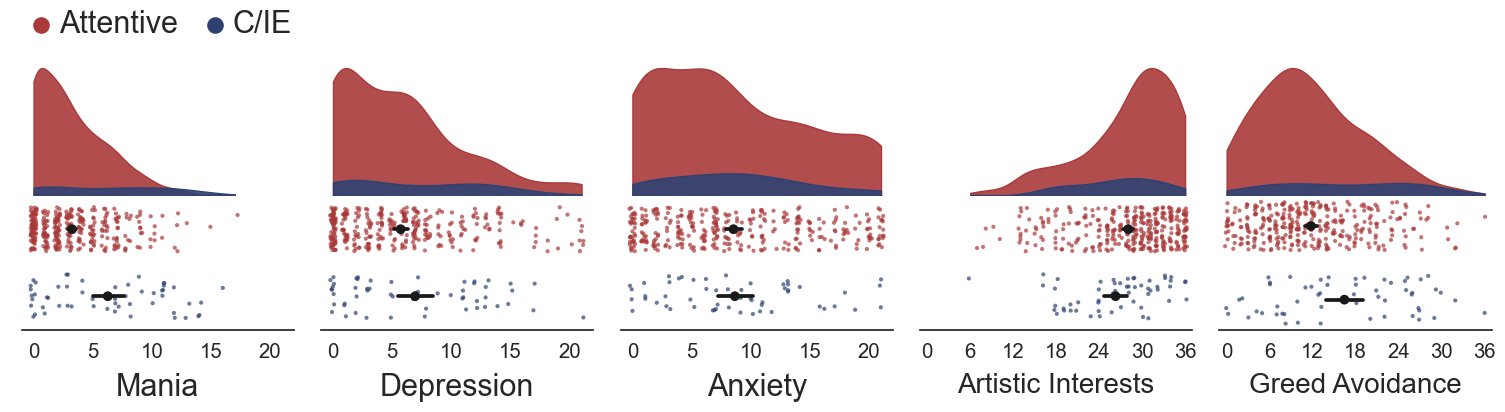

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(15,4))
                         
## Initialize grid.
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.01, right=0.99, top=0.85, bottom=0.18, wspace=0.1, hspace=0.3)

## Initialize panels.
panels = []
for i in range(5): panels.append( gs[i].subgridspec(nrows=2, ncols=1, wspace=0, hspace=0) )
    
## Define order.
order = ['mania', 'depression', 'anxiety', 'artistic', 'greed']

## Define titles.
titles = ['Mania', 'Depression', 'Anxiety', 'Artistic Interests', 'Greed Avoidance']

## Define axis limits.
xlims = [(-1,22),(-1,22),(-1,22),(-1,37),(-1,37)]
xticks = [np.arange(0,21,5),np.arange(0,21,5),np.arange(0,21,5),np.arange(0,37,6),np.arange(0,37,6)]

## Define aesthetic features.
palette = ['#AA3939','#2E4272']
labelpad = 8

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

for i, survey in enumerate(order):   
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Distribution plots.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize axis.
    ax = plt.subplot(panels[i][0])
    
    ## Plot distribution of scores.
    sns.kdeplot(x=survey, hue='infreq', data=data, hue_order=[1,0], common_grid=True, legend=False,
                palette=palette[::-1], fill=True, cut=0, alpha=0.9, ax=ax)
    
    ## Add details.
    ax.set(xlim=xlims[i], xticks=[], xlabel='', yticks=[], ylabel='')
    sns.despine(left=True, right=True, top=True, bottom=True, ax=ax)
            
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Point plots.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize axis.
    ax = plt.subplot(panels[i][1])
        
    ## Plot central tendency.
    sns.pointplot(y='infreq', x=survey, data=data, order=[0,1], orient='h', color='k',
                  markers='o', scale=0.8, join=False, ci=95, edgecolor='k', zorder=10, ax=ax)
    
    ## Add small jitter to scores.
    data['jitter'] = data[survey] + np.random.uniform(-0.25,0.25,data[survey].size)
        
    ## Plot individual scores.
    sns.stripplot(y='infreq', x='jitter', data=data, order=[0,1], orient='h', palette=palette,
                   size=3, alpha=0.7, jitter=0.33, zorder=-1, ax=ax)
    
    ## Add details.
    ax.set(xlim=xlims[i], xticks=xticks[i], yticks=[], ylabel='')
    ax.set_xlabel(titles[i], fontsize=22 if len(titles[i]) <= 10 else 20, labelpad=labelpad)
    sns.despine(left=True, ax=ax)

## Add legend.
ax.scatter([], [], s=120, color=palette[0], label='Attentive')
ax.scatter([], [], s=120, color=palette[1], label='C/IE')
ax.legend(loc=1, bbox_to_anchor=(-3.35, 2.5), frameon=False, ncol=2, fontsize=22, 
          borderpad=0, handletextpad=-0.4, columnspacing=0.2)
    
## Save figure.
plt.savefig(os.path.join('figures', 'repl_02a.png'), dpi=180, transparent=True)